# Tutorial: **$\delta$ HBV 1.1p**

---

This notebook demonstrates how to train and forward the $\delta$ HBV 1.1p model developed by [Yalan Song et al. (2024)](https://essopenarchive.org/users/810569/articles/1213791-improving-physics-informed-differentiable-hydrologic-models-for-capturing-unseen-extreme-events?commit=9860e1a182de65bf97f387c3d7021868dcc52081). A pre-trained model is provided for those who only wish to run the forward. For explanation of model structure, methodologies, data, and performance metrics, please refer to Song's publication [below](#publication). If you find this code is useful in your own work, please include the aforementioned citation.

<br>

#### Before Running:
- **Environment**: From `env/` a minimal Python environment can be setup for running this code... (see `docs/getting_started.md` for more details.)
    - Conda -- `deltamodel_env.yaml`
    - Pip -- `requirements.txt`


- **Model**: The trained $\delta$ HBV 1.1p model can be downloaded from [AWS](https://mhpi-spatial.s3.us-east-2.amazonaws.com/mhpi-release/models/dHBV_1_1p_trained.zip). After downloading...

    - Update the `trained_model` key in model config `example/conf/config_dhbv_1_1p.yaml` with the path to you directory containing the trained model `dHBV_1_1p_Ep50.pt` (or *Ep100*) AND normalization file `statics_basinnorm.json`.

- **Data**: The CAMELS data extraction used in model training and evaluation can be downloaded from [AWS](https://mhpi-spatial.s3.us-east-2.amazonaws.com/mhpi-release/camels/camels_data.zip). After downloading, in the data configs `example/conf/observations/camels_531.yaml` and `camels_671.yaml` update...
    1. `train_path` key with your path to `training_file`,
    2. `test_path` with your path to `valication file`,
    3. `gage_info` with your path to `gage_ids.npy`,
    4. (CAMELS 531 only) `subset_path` with your path to `531_subset.txt`.

    
### Publication:

*Yalan Song, Kamlesh Sawadekar, Jonathan M Frame, Ming Pan, Martyn Clark, Wouter J M Knoben, Andrew W Wood, Trupesh Patel, Chaopeng Shen. 'Improving physics-informed, differentiable hydrologic models for capturing unseen extreme events.' ESS Open Archive (2024). https://doi.org/10.22541/essoar.172304428.82707157/v1.*

---

## 1.1 Train $\delta$ HBV 1.1p

After completing [these](#before-running) steps (model file not needed), train a $\delta$ HBV 1.1p model with the code block below.

--> For default settings with 50 training epochs, expect train times of ~8 hours with an Nvidia RTX 3090.

**Note**
- The settings defined in `../example/conf/config_dhbv_1_1p.yaml` are set to replecate benchmark performance.
- For model training, set `mode: train` in `example/conf/config_dhbv_1_1p.yaml`, or modify after config dict has been created (see below).
- An `example/results/` directory will be generated to store experiment and model files. This location can be adjusted by changing the `save_path` key in your config. 
- If you are new to the *dMG* framework and want explanation of the methods used below, we suggest first looking at our notebook for $\delta$ HBV 1.0: `example/hydrology/example_dhbv_1_0.ipynb`.


In [ ]:
import sys
sys.path.append('../../')
sys.path.append('../../deltaModel')  # Add the dMG root directory.

from example import load_config 
from models.model_handler import ModelHandler as dHBV
from core.utils import print_config
from core.utils.module_loaders import get_data_loader, get_trainer



# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_1p.yaml'


# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'train'  # <-- Confirm that we are doing training if not set in the config file.
print_config(config)

# 2. Initialize the differentiable HBV 1.1p model (LSTM + HBV 1.1p).
model = dHBV(config, verbose=True)

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
data_loader = get_data_loader(config['data_loader'])
data_loader = data_loader(config, test_split=True, overwrite=False)
train_dataset = data_loader.train_dataset

# 4. Initialize trainer to handle model training.
trainer = get_trainer(config['trainer'])
trainer = trainer(
    config,
    model,
    train_dataset = train_dataset,
    verbose=True,
)

# 5. Start model training.
trainer.train()

## 1.2 Evaluate Model Performance

After completing the training in [1.1](#11-train--hbv-11p), or with the trained model provided, test $\delta$ HBV 1.1p below on the evaluation data.

--> For default settings expect evaluation time of ~5 minutes with an Nvidia RTX 3090.

**Note**
- For model evaluation, set `mode: test` in `example/conf/config_dhbv_1_1p.yaml`, or modify after config dict has been created (see below).
- When evaluating provided models, confirm that `test: test_epoch` in the config corresponds to your desired model (50 or 100 epochs).

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../deltaModel')  # Add the dMG root directory.

from example import load_config 
from models.model_handler import ModelHandler as dHBV
from core.utils import print_config
from core.utils.module_loaders import get_data_loader, get_trainer



# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_1p.yaml'


# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'test'  # <-- Confirm that we are doing testing if not set in the config file.
print_config(config)

# 2. Initialize the differentiable HBV 1.1p model (LSTM + HBV 1.1p).
model = dHBV(config, verbose=True)

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
data_loader = get_data_loader(config['data_loader'])
data_loader = data_loader(config, test_split=True, overwrite=False)
eval_dataset = data_loader.eval_dataset

# 4. Initialize trainer to handle model evaluation.
trainer = get_trainer(config['trainer'])
trainer = trainer(
    config,
    model,
    eval_dataset = eval_dataset,
    verbose=True,
)

# 5. Start testing the model.
print('Evaluating model...')
trainer.evaluate()


Current Configuration
  Experiment Mode:    test                
  Model 1:            HBV_1_1p            

Data Loader
  Data Source:        camels_531          
  Test Range :        1989/10/01          1999/09/30          

Model Parameters
  Train Epochs:       100                 Batch Size:         100                 
  Dropout:            0.5                 Hidden Size:        256                 
  Warmup:             365                 Concurrent Models:  16                  
  Loss Fn:            NseLossBatch        

Machine
  Use Device:         cuda:1              



KeyboardInterrupt: 

### Visualizing Trained Model Performance

After running evaluation on the model, a new directory (e.g., for a model trained for 50 epochs and tested from years 1989-1999), `test1989-1999_Ep50/` will be created in the same directory containing the model files. This path will be populated with...

1. All model outputs (fluxes, states), including the target variable, *streamflow* (`flow_sim.npy`),

2. `flow_sim_obs`, streamflow observation data for comparison against model predictions,

2. `metrics.json`, containing evaluation metrics accross the test time range for every gage in the dataset,

3. `metrics_agg.json`, containing evaluation metrics statistics across all gages (mean, median, standar deviation).


We can use these outputs to visualize $\delta$ HBV 1.1p's performance with a 
1. Cumulative distribution function (CDF) plot, 

2. CONUS map of gage locations and metric (e.g., NSE) performance.

<br>

But first, let's first check the (basin-)aggregated metrics for NSE, KGE, bias, RMSE, and, for both high/low flow regimes, RMSE and absolute percent bias...

In [2]:
import os

from core.post import print_metrics
from core.data import load_json


print(f"Evaluation output files saved to: {config['out_path']} \n")


# 1. Load the basin-aggregated evaluation results.
metrics_path = os.path.join(config['out_path'], 'metrics_agg.json')
metrics = load_json(metrics_path)

# 2. Print the evaluation results.
metric_names =  [
    # Choose metrics to show.
    'nse', 'kge', 'bias', 'rmse', 'rmse_low', 'rmse_high', 'flv_abs', 'fhv_abs',
]
print_metrics(metrics, metric_names, mode='median', precision=3)

Evaluation output files saved to: ../results/camels_531/train1999-2008/no_multi/LSTM_E100_R365_B100_H256_n16_noLn_noWU_111111/HBV_1_1p/NseLossBatch/3dyn/parBETA_parK0_parBETAET/test1989-1999_Ep50 

Median of Metrics (Prec: 3 digits):
----------------------------------------
Nse: 0.742
Kge: 0.739
Bias: 0.520
Rmse: 1.246
Rmse_low: 0.064
Rmse_high: 3.540
Flv_abs: 45.509
Fhv_abs: 17.723
----------------------------------------


### Generate the CDF


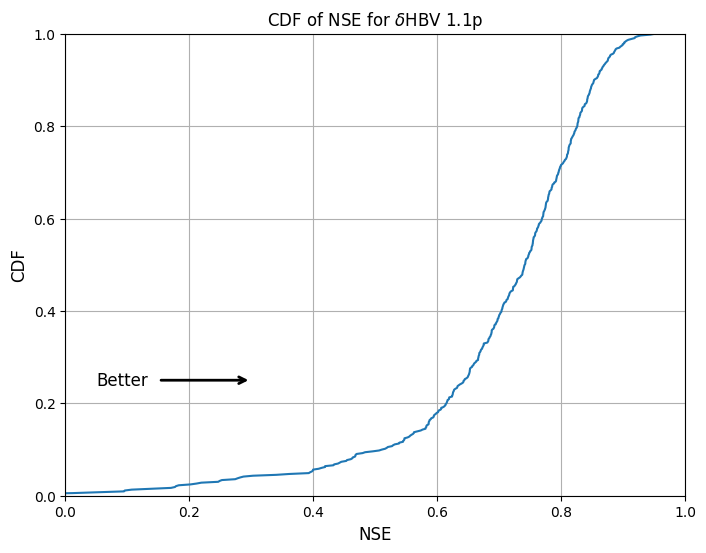

In [4]:
### Plot CDF of the evaluation results.
from core.post.plot_cdf import plot_cdf


# 1. Load the evaluation metrics.
metrics_path = os.path.join(config['out_path'], 'metrics.json')
metrics = load_json(metrics_path)

# 2. Plot the CDF for NSE.
plot_cdf(
    metrics=[metrics],
    metric_names=['nse'],
    model_labels=['dHBV 1.1p'],
    title="CDF of NSE for $\delta$HBV 1.1p",
    xlabel='NSE',
    figsize=(8, 6),
    xbounds=(0, 1),
    ybounds=(0, 1),
    show_arrow=True
)

In [26]:
### Plot the evaluation results spatially.
import geopandas as gpd


# Set the path to the shapefile containing the basin loacations.
shapefile_path = '/projects/mhpi/lglonz/project_silmaril/generic_deltaModel/example/hydrology/camels_671_loc.shp' # 'your/path/to/camels_671_loc.shp'  # <-- Change this to the path of the shapefile.
gage_id_path = '/projects/mhpi/lglonz/data/extracted/gageid.npy'  # 'your/path/to/gageid.npy'  # <-- Change this to the path of the gage ID file.
gage_id_531_path = '/projects/mhpi/lglonz/data/extracted/Sub531ID.txt'  # 'your/path/to/Sub531ID.txt'  # <-- Change this to the path of the Sub531 ID file.


# 1. Load the evaluation metrics.
metrics_path = os.path.join(config['out_path'], 'metrics.json')
metrics = load_json(metrics_path)

# 2. Load basin shapefile containing geocoordinates (lat, long) for every gage.
coords = gpd.read_file(shapefile_path)




In [29]:
import numpy as np

gage_ids = np.load(gage_id_path, allow_pickle=True)

# Read file, clean brackets, and split into integers
with open(gage_id_531_path, 'r') as f:
    lines = f.read().strip()  # Remove extra whitespace
    lines = lines.replace("[", "").replace("]", "")  # Remove brackets
gage_ids_531 = np.array([int(x) for x in lines.split(",")])


In [ ]:
def txt_to_gageid(txt_path: str):
    with open(txt_path, 'r') as f:
        lines = f.read().strip()  # Remove extra whitespace
        lines = lines.replace("[", "").replace("]", "")  # Remove brackets
    return np.array([int(x) for x in lines.split(",")])

## 2. Forward $\delta$ HBV 1.1p

After completing [these](#before-running) steps, forward the $\delta$ HBV 1.1p model with the code block below.

Note:
- The settings defined in `../example/conf/config_dhbv_2_0.yaml` are set to replecate benchmark performance.
- If you are new to the *dMG* framework and want more explanation and exposure of the methods used below, we suggest first looking at our notebook for $\delta$ HBV 1.0: `example/hydrology/tutorial_dhbv.ipynb`.

In [ ]:
import sys
sys.path.append('../../')
sys.path.append('../../deltaModel')  # Add the dMG root directory.

from example import load_config 
from hydroDL2.models.hbv.hbv import HBV as hbv
from deltaModel.models.neural_networks import init_nn_model
from models.model_handler import ModelHandler as dHBV
from core.data.data_loaders.loader_hydro import HydroDataLoader
from core.data.data_samplers.sampler_hydro import take_sample
from core.utils import print_config
from core.utils.module_loaders import get_data_loader, get_trainer



# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_2_0.yaml'


# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
print_config(config)

# 2. Setup a dataset dictionary of NN and physics model inputs.
data_loader = get_data_loader(config['data_loader'])
data_loader = data_loader(config, test_split=True, overwrite=False)

# 3. Initialize the differentiable model dHBV 2.0 (LSTM + HBV 2.0).
model = dHBV(config, verbose=True)

# 4. Initialize trainer to handle forward pass.
trainer = get_trainer(config['trainer'])
trainer = trainer(
    config,
    model,
    eval_dataset = data_loader.eval_dataset,
    verbose=True,
)

# 5. Forward pass through the model to get streamflow predictions.
predictions = trainer.forward()

## 2. Visualize the Predictions

We plot a hydrograph of the resulting predictions below, streamflow on a hydrograph for instance.

In [ ]:
# TODO: Include hydrograph plot here.